In [ ]:
from notebooks import *

In [ ]:
load = Load()
recs = recs if 'recs' in locals() else load.recs(
    # limit=30,  # XXX Faster dev
    datasets=[
        'peterson-field-guide',
        # 'recordings',
    ],
)
display(
    # df_summary(recs).T,
    # df_summary(recs),
    # recs[:5],
)

In [ ]:
# (recs
#     .assign(species=lambda df: df.species_longhand)
#     .assign(count=1)
#     # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
#     .pipe(lambda df: df.append(
#         pd.DataFrame([
#             dict(species=species, dataset=dataset, duration_s=0)
#             for species in df.species.unique()
#             for dataset in df.dataset.unique()
#         ])
#         .astype({'species': df.species.dtype})
#     ))
#     .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
#     .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
#     .pipe(df_reverse_cat, 'species')
#     .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
#     + coord_flip()
#     + geom_bar(stat='identity', position=position_dodge(), width=.8)
#     + facet_wrap('variable', nrow=1, scales='free')
#     + xlab('')
#     + ylab('')
#     + scale_fill_cmap_d(mpl.cm.tab10)
#     + scale_color_cmap_d(mpl.cm.tab10)
#     + theme(panel_spacing=2.5)
#     + theme_figsize(width=10, aspect_ratio=3/1)
#     + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
# )

In [ ]:
# Load a saved projection model
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[01:16:36.345] Projection.load
  path: /Users/danb/hack/bubo/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Add .feat
recs = projection.transform(recs)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[#####                                                                                     ] | 6% Completed |  0.2s

[##################                                                                        ] | 20% Completed |  0.3s

[####################################                                                      ] | 41% Completed |  0.4s

[####################################                                                      ] | 41% Completed |  0.5s

[#######################################################                                   ] | 61% Completed |  0.6s

[#######################################################                                   ] | 61% Completed |  0.7s

[############################################################################              ] | 84% Completed |  0.9s

[##########################################################################################] | 100% Completed |  1.0s

In [ ]:
# Example CV (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
from sklearn import datasets, linear_model, model_selection
diabetes = datasets.load_diabetes()
X, y = diabetes.data[:150], diabetes.target[:150]
lasso = linear_model.Lasso()
DF(model_selection.cross_validate(
    lasso, X, y,
    cv=5,
    return_train_score=True,
    verbose=10,
    n_jobs=16,
))

[CV]  ................................................................


[CV]  ................................................................


[CV]  ................................................................


[CV]  ................................................................


[CV]  ................................................................


[CV] ...................... , score=0.22414974810014598, total=   0.0s


[CV] ....................... , score=0.2982875885219344, total=   0.0s


[CV] ...................... , score=0.15479913227922903, total=   0.0s


[CV] ....................... , score=0.2551969087315188, total=   0.0s


[CV] ....................... , score=0.1710903644830516, total=   0.0s


[Parallel(n_jobs=16)]: Batch computation too fast (0.0161s.) Setting batch_size=24.
[Parallel(n_jobs=16)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,test_score,train_score
0,0.003,8.390e-04,0.298,0.328
1,0.003,9.460e-04,0.224,0.315
2,0.003,9.270e-04,0.155,0.340
3,0.003,9.180e-04,0.255,0.321
4,0.003,8.790e-04,0.171,0.274


In [ ]:
# CV one model
search = Search(projection=projection,
    # n_neighbors=5,
)
X, y = search.Xy(recs)
with log.context(verbose=False):
    DF(model_selection.cross_validate(
        search, X, y,
        cv=3,  # TODO Get more instances per class, so that instances_per_class >> cv
        return_train_score=True,
        verbose=10,
        # n_jobs=1,  # Disable procs (e.g. for %debug)
        n_jobs=16,
    ))

[CV]  ................................................................


[CV]  ................................................................


[CV]  ................................................................


[CV] .................................... , score=-35.0, total=   0.9s


[CV] .................................... , score=-35.0, total=   0.7s


[CV] .................................... , score=-35.0, total=   0.8s


[Parallel(n_jobs=16)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   3 out of   3 | elapsed:    1.3s finished


In [ ]:
# Example GridSearchCV (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
params = dict(
    kernel=('linear', 'rbf'),
    C=[1, 10],
)
iris = sk.datasets.load_iris()
select = sk.model_selection.GridSearchCV(
    sk.svm.SVC(),
    params,
    cv=3,
    return_train_score=True,
    verbose=10,
    n_jobs=16,
)
select.fit(iris.data, iris.target)
cv_results_dfs(select.cv_results_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[CV] C=1, kernel=linear ..............................................


[CV] C=1, kernel=linear ..............................................


[CV] C=1, kernel=linear ..............................................


[CV] C=1, kernel=rbf .................................................


[CV] C=1, kernel=rbf .................................................


[CV] C=1, kernel=rbf .................................................


[CV] C=10, kernel=linear .............................................


[CV] .................... C=1, kernel=linear, score=1.0, total=   0.0s


[CV] ..... C=1, kernel=linear, score=0.9607843137254902, total=   0.0s


[CV] C=10, kernel=linear .............................................


[CV] ..... C=1, kernel=linear, score=0.9791666666666666, total=   0.0s


[CV] ........ C=1, kernel=rbf, score=0.9607843137254902, total=   0.0s


[CV] C=10, kernel=linear .............................................


[CV] C=10, kernel=rbf ................................................


[CV] ........ C=1, kernel=rbf, score=0.9791666666666666, total=   0.0s


[CV] .... C=10, kernel=linear, score=0.9215686274509803, total=   0.0s


[CV] ........ C=1, kernel=rbf, score=0.9803921568627451, total=   0.0s


[CV] C=10, kernel=rbf ................................................


[CV] ................... C=10, kernel=linear, score=1.0, total=   0.0s


[CV] C=10, kernel=rbf ................................................


[CV] ...................... C=10, kernel=rbf, score=1.0, total=   0.0s


[CV] ....... C=10, kernel=rbf, score=0.9803921568627451, total=   0.0s


[CV] ....... C=10, kernel=rbf, score=0.9607843137254902, total=   0.0s


[CV] ................... C=10, kernel=linear, score=1.0, total=   0.0s


[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Batch computation too fast (0.0253s.) Setting batch_size=14.
[Parallel(n_jobs=16)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  12 out of  12 | elapsed:    0.0s finished


(
    param_C param_kernel  mean_train_score  std_train_score  mean_test_score  std_test_score  rank_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time
  0       1       linear             0.990            0.008            0.980           0.016                1          0.003     1.437e-04        8.233e-04       2.521e-05
  1       1          rbf             0.983            0.013            0.973           0.009                3          0.003     1.495e-04        7.885e-04       3.691e-05
  2      10       linear             0.980            0.016            0.973           0.037                3          0.002     1.983e-04        7.245e-04       5.297e-06
  3      10          rbf             0.980            0.016            0.980           0.016                1          0.003     9.373e-05        8.694e-04       4.922e-05,
     param_C param_kernel fold  split  score
  0        1       linear    0   test  1.000
  1        1       linear    0  train  0.980
  

In [ ]:
# GridSearchCV many models / model params
params = dict(
    classifier = [
        'cls: knn, n_neighbors: 1',
        'cls: knn, n_neighbors: 3',
        'cls: knn, n_neighbors: 5',
        'cls: knn, n_neighbors: 10',
        'cls: knn, n_neighbors: 15',
        # 'cls: knn, n_neighbors: 25',
        'cls: knn, n_neighbors: 50',
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1',
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10',  # Like [SBF16]
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100',
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # Defaults
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # Like [SP14]
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',
        # TODO
    ]
    # TODO agg_funs
)
search = Search(projection=projection)
X, y = search.Xy(recs)
select = sk.model_selection.GridSearchCV(
    Search(projection=projection),
    params,
    # cv=3,  # [SP14] uses two-/three-fold CV [TODO why?]
    cv=model_selection.ShuffleSplit(
        # n_splits=1,
        # n_splits=10,
        n_splits=20,
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=8,
    n_jobs=16,
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect?]
    stack.enter_context(log.context(verbose=False))
    select.fit(X, y)

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.4s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   27.0s


[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:   46.9s finished


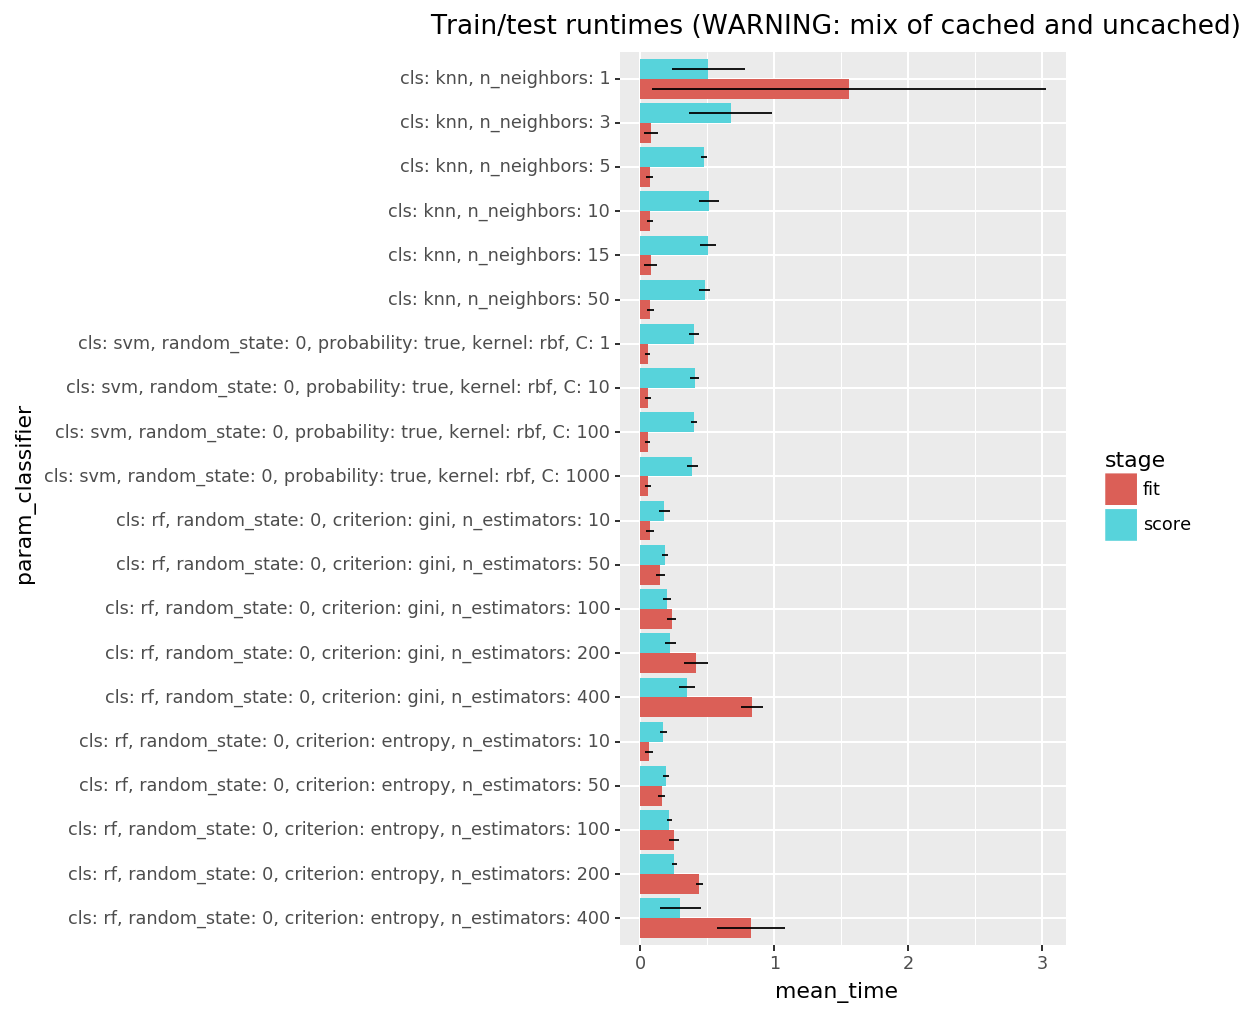

In [ ]:
with warnings.catch_warnings():
    # TODO How to avoid the 'color' legend warning since geom_col has no color mapping?
    warnings.simplefilter(action='ignore', category=UserWarning)
    repr(cv_results_summary_df(select.cv_results_)
        .filter(regex='^(param_.*|.*_time$)')
        .pipe(df_flatmap, lambda row: [
            row.set_value('stage', 'fit').rename({'mean_fit_time': 'mean_time', 'std_fit_time': 'std_time'}),
            row.set_value('stage', 'score').rename({'mean_score_time': 'mean_time', 'std_score_time': 'std_time'}),
        ])
        .filter(regex='^(param.*|stage|mean_time|std_time)$')
        .pipe(df_ordered_cat, 'param_classifier', transform=reversed)
        .pipe(ggplot, aes(x='param_classifier'))
        + geom_col(aes(y='mean_time', fill='stage'), position=position_dodge())
        + geom_linerange(
            aes(group='stage', y='mean_time', ymin='mean_time - 1.96 * std_time', ymax='mean_time + 1.96 * std_time'),
            position=position_dodge(width=.9),
        )
        + coord_flip()
        + scale_color_cmap_d(mpl.cm.Set1)
        # + theme(legend_position='bottom')
        + theme_figsize(width=4, aspect_ratio=2/1)
        + ggtitle('Train/test runtimes (WARNING: mix of cached and uncached)')
    )

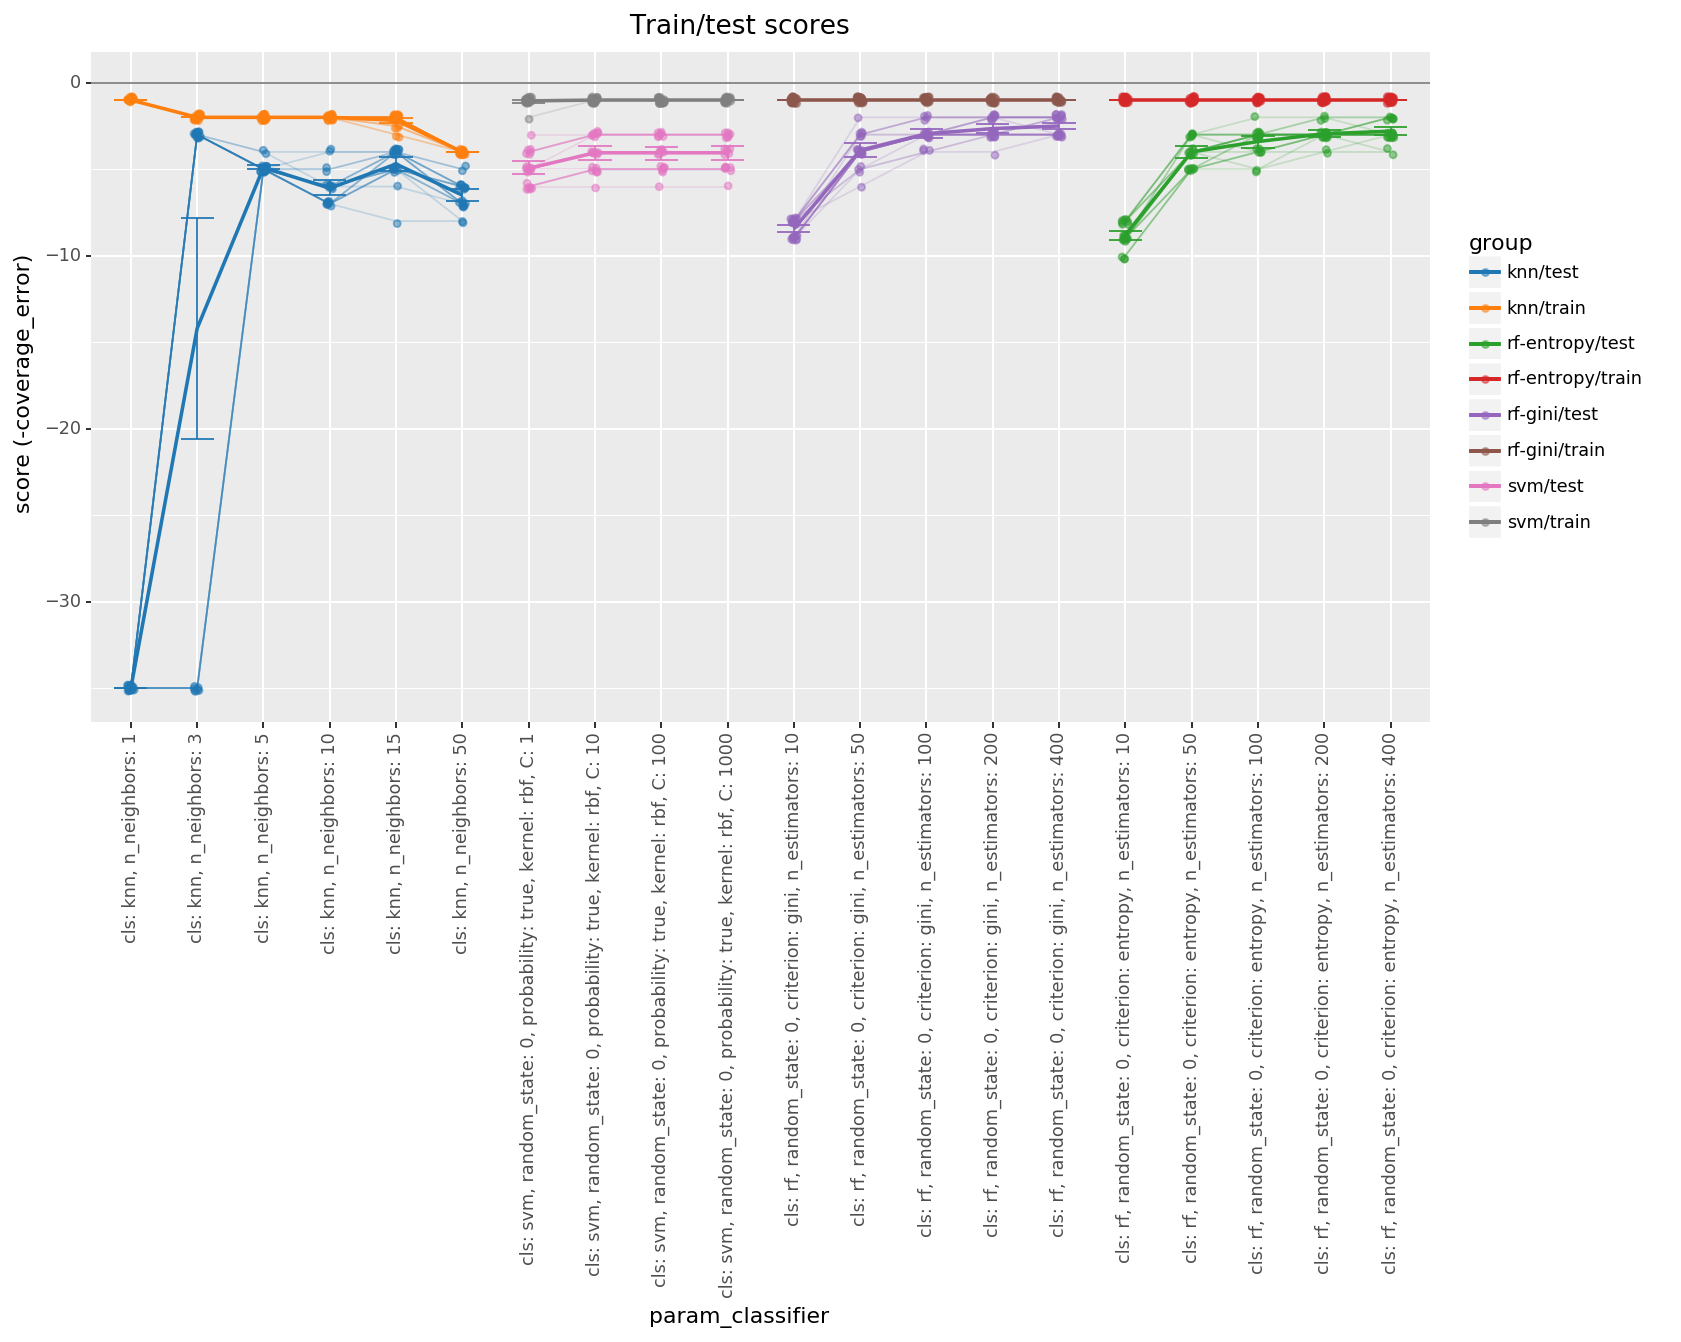

<ggplot: (-9223372036555344689)>

In [ ]:
(cv_results_splits_df(select.cv_results_)
    .assign(
        classifier_config=lambda df: df.param_classifier.apply(lambda x: yaml.safe_load('{%s}' % x)),
        type=lambda df: df.classifier_config.apply(lambda x: (
            '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
            x['cls']
        )),
        group=lambda df: df.apply(axis=1, func=lambda row: row.type + '/' + row.split),
    )
    .pipe(df_ordered_cat, param_classifier=lambda df: params['classifier'])
    .pipe(ggplot, aes(x='param_classifier', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05)
    + geom_line(aes(group='group + fold'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

In [ ]:
cv_splits = list(select.cv.split(range(len(recs))))
with log.context(verbose=False):
    models = (
        DF([
            OrderedDict(
                model_id='%s; fold: %s' % (param_classifier, fold),
                param_classifier=param_classifier,
                fold=fold,
                train_i=train_i,
                test_i=test_i,
            )
            for param_classifier in params['classifier']
            for fold, (train_i, test_i) in enumerate(cv_splits
                # [:2]  # XXX dev
            )
            for X, y in [Search.Xy(recs)]
        ])
        # [:3]  # XXX dev
        .pipe(
            df_apply_with_progress,
            # use='sync',  # [~30s]
            use='dask', scheduler='threads', npartitions=16,  # [~20-30s]
            # use='joblib', backend='threading', n_jobs=16, verbose=10,  # [~20-30s]
            # use='joblib', backend='threading', n_jobs=16, verbose=100,
            f=lambda row: row.append(S(dict(
                search=(
                    sk.base.clone(select.estimator)
                    .set_params(classifier=row.param_classifier)
                    .fit(
                        Search.X(recs)[row.train_i],
                        Search.y(recs)[row.train_i],
                    )
                ),
            ))),
        )
    )

display(
    len(params['classifier']),
    len(cv_splits),
    models.shape,
    models[:1].T,
)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[                                                                                          ] | 0% Completed |  0.2s

[                                                                                          ] | 0% Completed |  0.3s

[                                                                                          ] | 0% Completed |  0.4s

[                                                                                          ] | 0% Completed |  0.5s

[                                                                                          ] | 0% Completed |  0.6s

[                                                                                          ] | 0% Completed |  0.7s

[                                                                                          ] | 0% Completed |  0.8s

[                                                                                          ] | 0% Completed |  0.9s

[                                                                                          ] | 0% Completed |  1.0s

[                                                                                          ] | 0% Completed |  1.1s

[                                                                                          ] | 0% Completed |  1.2s

[                                                                                          ] | 0% Completed |  1.3s

[                                                                                          ] | 0% Completed |  1.4s

[                                                                                          ] | 0% Completed |  1.5s

[                                                                                          ] | 0% Completed |  1.7s

[                                                                                          ] | 0% Completed |  1.8s

[                                                                                          ] | 0% Completed |  1.9s

[                                                                                          ] | 0% Completed |  2.0s

[                                                                                          ] | 0% Completed |  2.1s

[                                                                                          ] | 0% Completed |  2.2s

[                                                                                          ] | 0% Completed |  2.3s

[                                                                                          ] | 0% Completed |  2.4s

[                                                                                          ] | 0% Completed |  2.5s

[###########                                                                               ] | 12% Completed |  2.6s

[################                                                                          ] | 18% Completed |  2.7s

[################                                                                          ] | 18% Completed |  2.8s

[################                                                                          ] | 18% Completed |  2.9s

[################                                                                          ] | 18% Completed |  3.0s

[######################                                                                    ] | 25% Completed |  3.1s

[##############################                                                            ] | 34% Completed |  3.2s

[#######################################                                                   ] | 43% Completed |  3.3s

[##########################################                                                ] | 46% Completed |  3.4s

[#############################################                                             ] | 50% Completed |  3.5s

[#############################################                                             ] | 50% Completed |  3.6s

[#############################################                                             ] | 50% Completed |  3.7s

[#############################################                                             ] | 50% Completed |  3.8s

[#############################################                                             ] | 50% Completed |  3.9s

[#############################################                                             ] | 50% Completed |  4.0s

[#############################################                                             ] | 50% Completed |  4.1s

[#############################################                                             ] | 50% Completed |  4.2s

[#############################################                                             ] | 50% Completed |  4.4s

[#############################################                                             ] | 50% Completed |  4.5s

[#############################################                                             ] | 50% Completed |  4.6s

[#############################################                                             ] | 50% Completed |  4.7s

[#############################################                                             ] | 50% Completed |  4.8s

[#############################################                                             ] | 50% Completed |  4.9s

[#############################################                                             ] | 50% Completed |  5.0s

[#############################################                                             ] | 50% Completed |  5.1s

[#############################################                                             ] | 50% Completed |  5.2s

[#############################################                                             ] | 50% Completed |  5.3s

[#############################################                                             ] | 50% Completed |  5.4s

[#############################################                                             ] | 50% Completed |  5.5s

[#############################################                                             ] | 50% Completed |  5.6s

[#############################################                                             ] | 50% Completed |  5.7s

[#############################################                                             ] | 50% Completed |  5.8s

[#############################################                                             ] | 50% Completed |  5.9s

[#############################################                                             ] | 50% Completed |  6.0s

[#############################################                                             ] | 50% Completed |  6.1s

[#############################################                                             ] | 50% Completed |  6.2s

[#############################################                                             ] | 50% Completed |  6.4s

[#############################################                                             ] | 50% Completed |  6.5s

[#############################################                                             ] | 50% Completed |  6.6s

[#############################################                                             ] | 50% Completed |  6.7s

[#############################################                                             ] | 50% Completed |  6.8s

[#############################################                                             ] | 50% Completed |  6.9s

[#############################################                                             ] | 50% Completed |  7.0s

[#############################################                                             ] | 50% Completed |  7.1s

[#############################################                                             ] | 50% Completed |  7.2s

[#############################################                                             ] | 50% Completed |  7.3s

[#############################################                                             ] | 50% Completed |  7.4s

[#############################################                                             ] | 50% Completed |  7.5s

[#############################################                                             ] | 50% Completed |  7.6s

[#############################################                                             ] | 50% Completed |  7.7s

[##################################################                                        ] | 56% Completed |  7.8s

[##################################################                                        ] | 56% Completed |  7.9s

[##################################################                                        ] | 56% Completed |  8.0s

[##################################################                                        ] | 56% Completed |  8.1s

[##################################################                                        ] | 56% Completed |  8.2s

[##################################################                                        ] | 56% Completed |  8.3s

[##################################################                                        ] | 56% Completed |  8.4s

[##################################################                                        ] | 56% Completed |  8.5s

[##################################################                                        ] | 56% Completed |  8.7s

[##################################################                                        ] | 56% Completed |  8.8s

[##################################################                                        ] | 56% Completed |  8.9s

[##################################################                                        ] | 56% Completed |  9.0s

[##################################################                                        ] | 56% Completed |  9.1s

[##################################################                                        ] | 56% Completed |  9.2s

[########################################################                                  ] | 62% Completed |  9.3s

[########################################################                                  ] | 62% Completed |  9.4s

[########################################################                                  ] | 62% Completed |  9.5s

[########################################################                                  ] | 62% Completed |  9.6s

[########################################################                                  ] | 62% Completed |  9.7s

[########################################################                                  ] | 62% Completed |  9.8s

[########################################################                                  ] | 62% Completed |  9.9s

[########################################################                                  ] | 62% Completed | 10.0s

[########################################################                                  ] | 62% Completed | 10.1s

[########################################################                                  ] | 62% Completed | 10.2s

[########################################################                                  ] | 62% Completed | 10.3s

[########################################################                                  ] | 62% Completed | 10.4s

[########################################################                                  ] | 62% Completed | 10.6s

[########################################################                                  ] | 62% Completed | 10.7s

[#############################################################                             ] | 68% Completed | 10.8s

[#############################################################                             ] | 68% Completed | 10.9s

[#############################################################                             ] | 68% Completed | 11.0s

[#############################################################                             ] | 68% Completed | 11.1s

[#############################################################                             ] | 68% Completed | 11.2s

[#############################################################                             ] | 68% Completed | 11.3s

[#############################################################                             ] | 68% Completed | 11.4s

[#############################################################                             ] | 68% Completed | 11.5s

[################################################################                          ] | 71% Completed | 11.6s

[###################################################################                       ] | 75% Completed | 11.7s

[###################################################################                       ] | 75% Completed | 11.8s

[###################################################################                       ] | 75% Completed | 11.9s

[###################################################################                       ] | 75% Completed | 12.0s

[###################################################################                       ] | 75% Completed | 12.1s

[###################################################################                       ] | 75% Completed | 12.2s

[###################################################################                       ] | 75% Completed | 12.4s

[###################################################################                       ] | 75% Completed | 12.5s

[###################################################################                       ] | 75% Completed | 12.6s

[###################################################################                       ] | 75% Completed | 12.7s

[###################################################################                       ] | 75% Completed | 12.8s

[###################################################################                       ] | 75% Completed | 12.9s

[###################################################################                       ] | 75% Completed | 13.0s

[###################################################################                       ] | 75% Completed | 13.1s

[###################################################################                       ] | 75% Completed | 13.2s

[###################################################################                       ] | 75% Completed | 13.3s

[###################################################################                       ] | 75% Completed | 13.4s

[###################################################################                       ] | 75% Completed | 13.5s

[###################################################################                       ] | 75% Completed | 13.6s

[###################################################################                       ] | 75% Completed | 13.7s

[###################################################################                       ] | 75% Completed | 13.8s

[###################################################################                       ] | 75% Completed | 13.9s

[###################################################################                       ] | 75% Completed | 14.0s

[###################################################################                       ] | 75% Completed | 14.1s

[###################################################################                       ] | 75% Completed | 14.2s

[#########################################################################                 ] | 81% Completed | 14.3s

[#########################################################################                 ] | 81% Completed | 14.5s

[#########################################################################                 ] | 81% Completed | 14.6s

[#########################################################################                 ] | 81% Completed | 14.7s

[#########################################################################                 ] | 81% Completed | 14.8s

[##############################################################################            ] | 87% Completed | 14.9s

[##############################################################################            ] | 87% Completed | 15.0s

[##############################################################################            ] | 87% Completed | 15.1s

[##############################################################################            ] | 87% Completed | 15.2s

[##############################################################################            ] | 87% Completed | 15.3s

[##############################################################################            ] | 87% Completed | 15.4s

[##############################################################################            ] | 87% Completed | 15.5s

[##############################################################################            ] | 87% Completed | 15.6s

[##############################################################################            ] | 87% Completed | 15.7s

[##############################################################################            ] | 87% Completed | 15.9s

[##############################################################################            ] | 87% Completed | 16.0s

[##############################################################################            ] | 87% Completed | 16.1s

[##############################################################################            ] | 87% Completed | 16.2s

[##############################################################################            ] | 87% Completed | 16.3s

[##############################################################################            ] | 87% Completed | 16.4s

[##############################################################################            ] | 87% Completed | 16.5s

[##############################################################################            ] | 87% Completed | 16.6s

[##############################################################################            ] | 87% Completed | 16.7s

[##############################################################################            ] | 87% Completed | 16.8s

[##############################################################################            ] | 87% Completed | 16.9s

[##############################################################################            ] | 87% Completed | 17.0s

[##############################################################################            ] | 87% Completed | 17.1s

[##############################################################################            ] | 87% Completed | 17.2s

[##############################################################################            ] | 87% Completed | 17.3s

[##############################################################################            ] | 87% Completed | 17.4s

[##############################################################################            ] | 87% Completed | 17.5s

[##############################################################################            ] | 87% Completed | 17.6s

[##############################################################################            ] | 87% Completed | 17.7s

[##############################################################################            ] | 87% Completed | 17.9s

[##############################################################################            ] | 87% Completed | 18.0s

[##############################################################################            ] | 87% Completed | 18.1s

[##############################################################################            ] | 87% Completed | 18.2s

[##############################################################################            ] | 87% Completed | 18.3s

[##############################################################################            ] | 87% Completed | 18.4s

[##############################################################################            ] | 87% Completed | 18.5s

[##############################################################################            ] | 87% Completed | 18.6s

[##############################################################################            ] | 87% Completed | 18.7s

[##############################################################################            ] | 87% Completed | 18.8s

[##############################################################################            ] | 87% Completed | 18.9s

[##############################################################################            ] | 87% Completed | 19.0s

[####################################################################################      ] | 93% Completed | 19.1s

[##########################################################################################] | 100% Completed | 19.2s

20

20

(400, 6)

,0
model_id,"cls: knn, n_neighbors: 1; fold: 0"
param_classifier,"cls: knn, n_neighbors: 1"
fold,0
train_i,[ 10 465 208 250 157 118 65 390 382 112 439 445 238 284 213 309 406 137 532 113 526 7 362 482 392 522 271 101 97\n 202 54 30 205 49 100 278 386 272 56 144 60 6 ...
test_i,[172 464 196 414 531 210 485 236 419 162 281 71 470 475 108 410 502 289 378 78 140 306 134 421 211 451 247 489 45\n 15 188 153 229 336 17 102 401 142 245 365 159 325 2...
search,"Search(projection=Projection(features=Features(load=Load(channels=1, sample_rate=22050, sample_width_bit=16, cache_audio=True), sample_rate=22050, f_min=1000, f_bins=40, ho..."


# Model diagnostics: all models, all folds

In [ ]:
# print("params['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(params['classifier'])))
# print()
print('models:')
print('  param_classifier[*/%s]' % len(params['classifier']))
print('  fold[*/%s]' % select.cv.n_splits)

models:
  param_classifier[*/20]
  fold[*/20]


# Model diagnostics: one model, all folds

In [ ]:
param_classifier_i = 17
param_classifier = params['classifier'][param_classifier_i]
print("params['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(params['classifier'])))
print()
print('models:')
print('  param_classifier[%s/%s]: %r' % (param_classifier_i, len(params['classifier']), param_classifier))
print('  fold[*/%s]' % select.cv.n_splits)

params['classifier']:
  0: 'cls: knn, n_neighbors: 1'
  1: 'cls: knn, n_neighbors: 3'
  2: 'cls: knn, n_neighbors: 5'
  3: 'cls: knn, n_neighbors: 10'
  4: 'cls: knn, n_neighbors: 15'
  5: 'cls: knn, n_neighbors: 50'
  6: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1'
  7: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10'
  8: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100'
  9: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000'
  10: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 10'
  11: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50'
  12: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100'
  13: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200'
  14: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400'
  15: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10'
  16: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50'
  17: 'c

In [ ]:
_row = models.iloc[0]
recs.iloc[_row.test_i]
_row.search.coverage_errors(*Search.Xy(recs.iloc[_row.test_i]))
_row.search.coverage_errors_recs(recs.iloc[_row.test_i])[:5]
recs[:5]

array([35., 35., 35., 35., 35., 35., 35., 35.,  1., 35., 35.,  1., 35., 35., 35., 35., 35.,  1., 35., 35., 35., 35.,
       35.,  1.,  1.,  1.,  1., 35.,  1., 35.,  1., 35., 35., 35., 35., 35.,  1., 35., 35., 35., 35., 35., 35., 35.,
       35., 35., 35., 35.,  1., 35.,  1., 35.,  1., 35., 35., 35.,  1.,  1.,  1.,  1., 35.,  1.,  1., 35., 35.,  1.,
        1., 35., 35., 35., 35., 35.,  1., 35.,  1., 35., 35.,  1., 35., 35., 35., 35.,  1., 35., 35.,  1., 35., 35.,
       35.,  1., 35., 35., 35., 35., 35., 35., 35.,  1., 35.,  1.,  1., 35., 35., 35.,  1., 35.,  1.])

,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path,filesize_b,feat,coverage_error
172,peterson-field-guide,BCTI,Black-crested Titmouse,blctit4,27.8,1.170,614016,43217991 Dee Series (couplet version),Black-crested Titmouse - BCTI,peterson-field-guide/blctit4/audio/43217991 Dee Series (couplet version),peterson-field-guide/blctit4/audio/43217991 Dee Series (couplet version).mp3,891089,[-1.130e-01 6.981e-02 2.204e-01 -9.129e-02 3.689e-02 1.182e-02 -1.379e-01 1.825e-02 -2.631e-01 3.651e-01\n -9.871e-02 1.086e-01 2.457e-01 -1.242e-01 2.456e-01 4.2...,35.0
464,peterson-field-guide,CEDW,Cedar Waxwing,cedwax,13.9,0.584,306432,43224741 Seet,Cedar Waxwing - CEDW,peterson-field-guide/cedwax/audio/43224741 Seet,peterson-field-guide/cedwax/audio/43224741 Seet.mp3,444708,[ 2.612e-02 1.771e-01 2.599e-02 -7.140e-02 -7.371e-02 3.954e-01 -1.438e-02 -6.217e-02 1.046e-01 -1.364e-01\n 1.706e-01 -3.487e-01 -1.665e-01 -5.203e-02 -1.492e-01 5.0...,35.0
196,peterson-field-guide,BUSH,Bushtit,bushti,11.2,0.471,247104,43218301 Trill (hoarse),Bushtit - BUSH,peterson-field-guide/bushti/audio/43218301 Trill (hoarse),peterson-field-guide/bushti/audio/43218301 Trill (hoarse).mp3,358609,[ 3.750e-02 3.582e-03 -1.319e-01 -3.853e-02 5.702e-04 -1.631e-01 1.603e-02 -2.673e-03 2.015e-02 -7.384e-02\n -1.388e-01 5.116e-01 -1.301e-02 9.868e-02 4.652e-01 -8.3...,35.0
414,peterson-field-guide,HETH,Hermit Thrush,herthr,22.2,0.933,489024,43222751 Whine,Hermit Thrush - HETH,peterson-field-guide/herthr/audio/43222751 Whine,peterson-field-guide/herthr/audio/43222751 Whine.mp3,709694,[-1.267e-01 1.105e-02 -3.031e-01 8.005e-02 2.129e-01 9.294e-02 3.648e-02 1.168e-01 -1.695e-01 1.225e-01\n 3.342e-02 -2.666e-01 7.605e-02 -1.128e-01 -2.570e-02 -1.2...,35.0
531,peterson-field-guide,SOSP,Song Sparrow,sonspa,36.4,1.530,801792,43236701 Song,Song Sparrow - SOSP,peterson-field-guide/sonspa/audio/43236701 Song,peterson-field-guide/sonspa/audio/43236701 Song.mp3,1163598,[-1.264e-01 3.170e-03 -3.281e-01 8.361e-02 2.744e-01 1.812e-01 -1.914e-01 -5.164e-02 -2.071e-01 -2.443e-01\n 1.575e-01 -2.838e-02 -6.013e-02 -7.986e-03 -4.910e-02 -7.8...,35.0


In [ ]:
coverage_errors_all = (models
    [lambda df: df.param_classifier == param_classifier]  # One model, all folds
    # [:2]  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            **row[['model_id', 'param_classifier', 'fold']],
            **out_row[['species', 'coverage_error', 'id']],
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for out_row in df_rows(row.search.coverage_errors_recs(recs.iloc[row.test_i]))
    ))
)
display(
    coverage_errors_all[:5],
)

,model_id,param_classifier,fold,species,coverage_error,id
0,"cls: rf, random_state: 0, criterion: entropy, n_estimators: 100; fold: 0","cls: rf, random_state: 0, criterion: entropy, n_estimators: 100",0,BCTI,4.0,peterson-field-guide/blctit4/audio/43217991 Dee Series (couplet version)
1,"cls: rf, random_state: 0, criterion: entropy, n_estimators: 100; fold: 0","cls: rf, random_state: 0, criterion: entropy, n_estimators: 100",0,CEDW,15.0,peterson-field-guide/cedwax/audio/43224741 Seet
2,"cls: rf, random_state: 0, criterion: entropy, n_estimators: 100; fold: 0","cls: rf, random_state: 0, criterion: entropy, n_estimators: 100",0,BUSH,5.0,peterson-field-guide/bushti/audio/43218301 Trill (hoarse)
3,"cls: rf, random_state: 0, criterion: entropy, n_estimators: 100; fold: 0","cls: rf, random_state: 0, criterion: entropy, n_estimators: 100",0,HETH,3.0,peterson-field-guide/herthr/audio/43222751 Whine
4,"cls: rf, random_state: 0, criterion: entropy, n_estimators: 100; fold: 0","cls: rf, random_state: 0, criterion: entropy, n_estimators: 100",0,SOSP,3.0,peterson-field-guide/sonspa/audio/43236701 Song


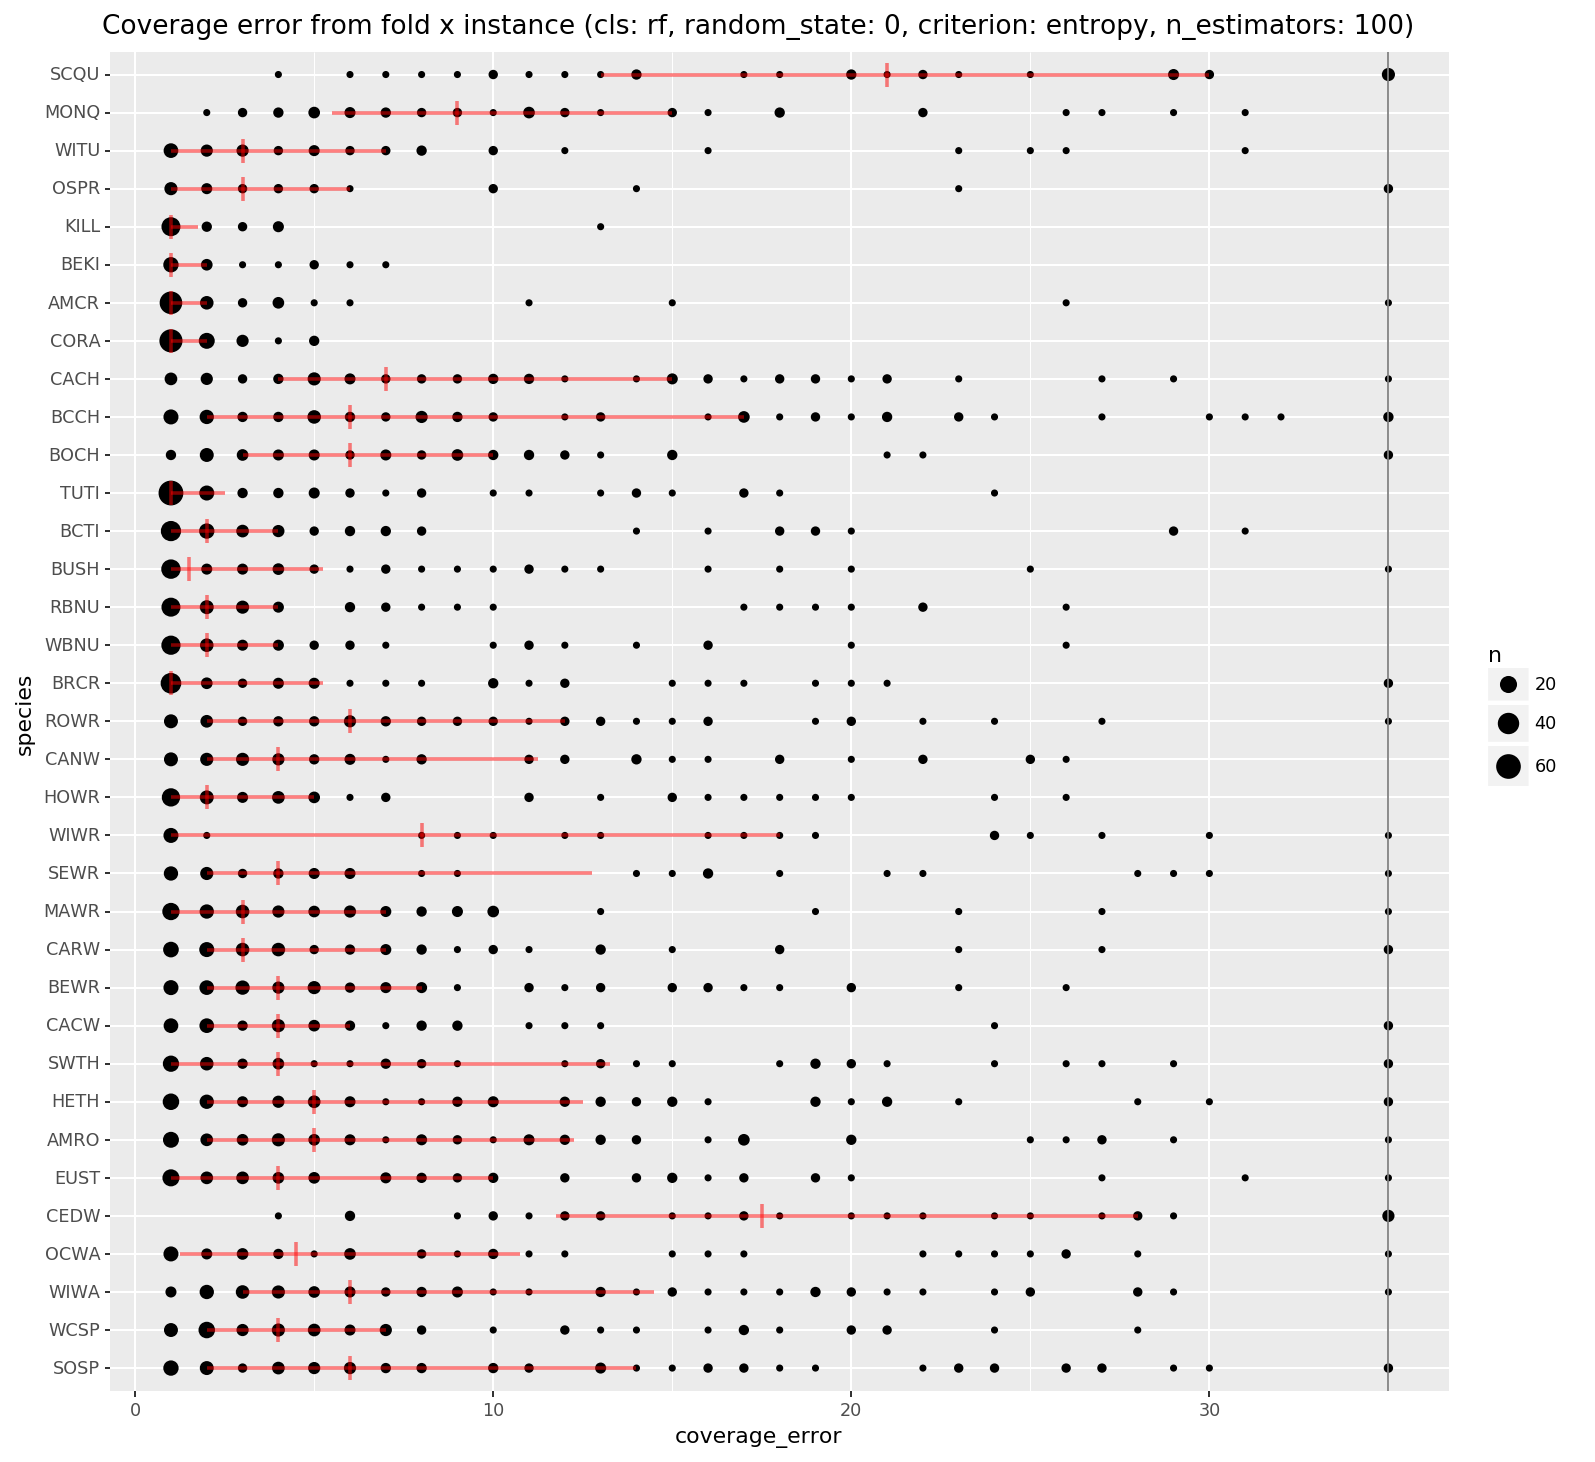

<ggplot: (586780343)>

In [ ]:
# in: coverage_errors_all, recs
(coverage_errors_all
    .pipe(ggplot, aes(x='species', y='coverage_error'))
    + geom_count(aes(size='..n..'))
    + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
    + stat_summary(
        fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75), geom='linerange', color='red', alpha=.5, size=1,
    )
    + coord_flip()
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_x_discrete(limits=list(reversed(recs.species.cat.categories)))
    + theme_figsize('square')
    + ggtitle(f'Coverage error from fold x instance ({param_classifier})')
)

In [ ]:
# in: param_classifier
coverage_errors_by_species = (models
    [lambda df: df.param_classifier == param_classifier]  # One model, all folds
    # [:5]  # Faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            **row[['model_id', 'param_classifier', 'fold']],
            **out_row.rename({'coverage_error': 'med_coverage_error'}),
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for out_row in df_rows(row.search.coverage_errors_recs_by(recs.iloc[row.test_i], 'species'))
    ))
)
display(
    df_summary(coverage_errors_by_species).T,
    coverage_errors_by_species[:5],
)

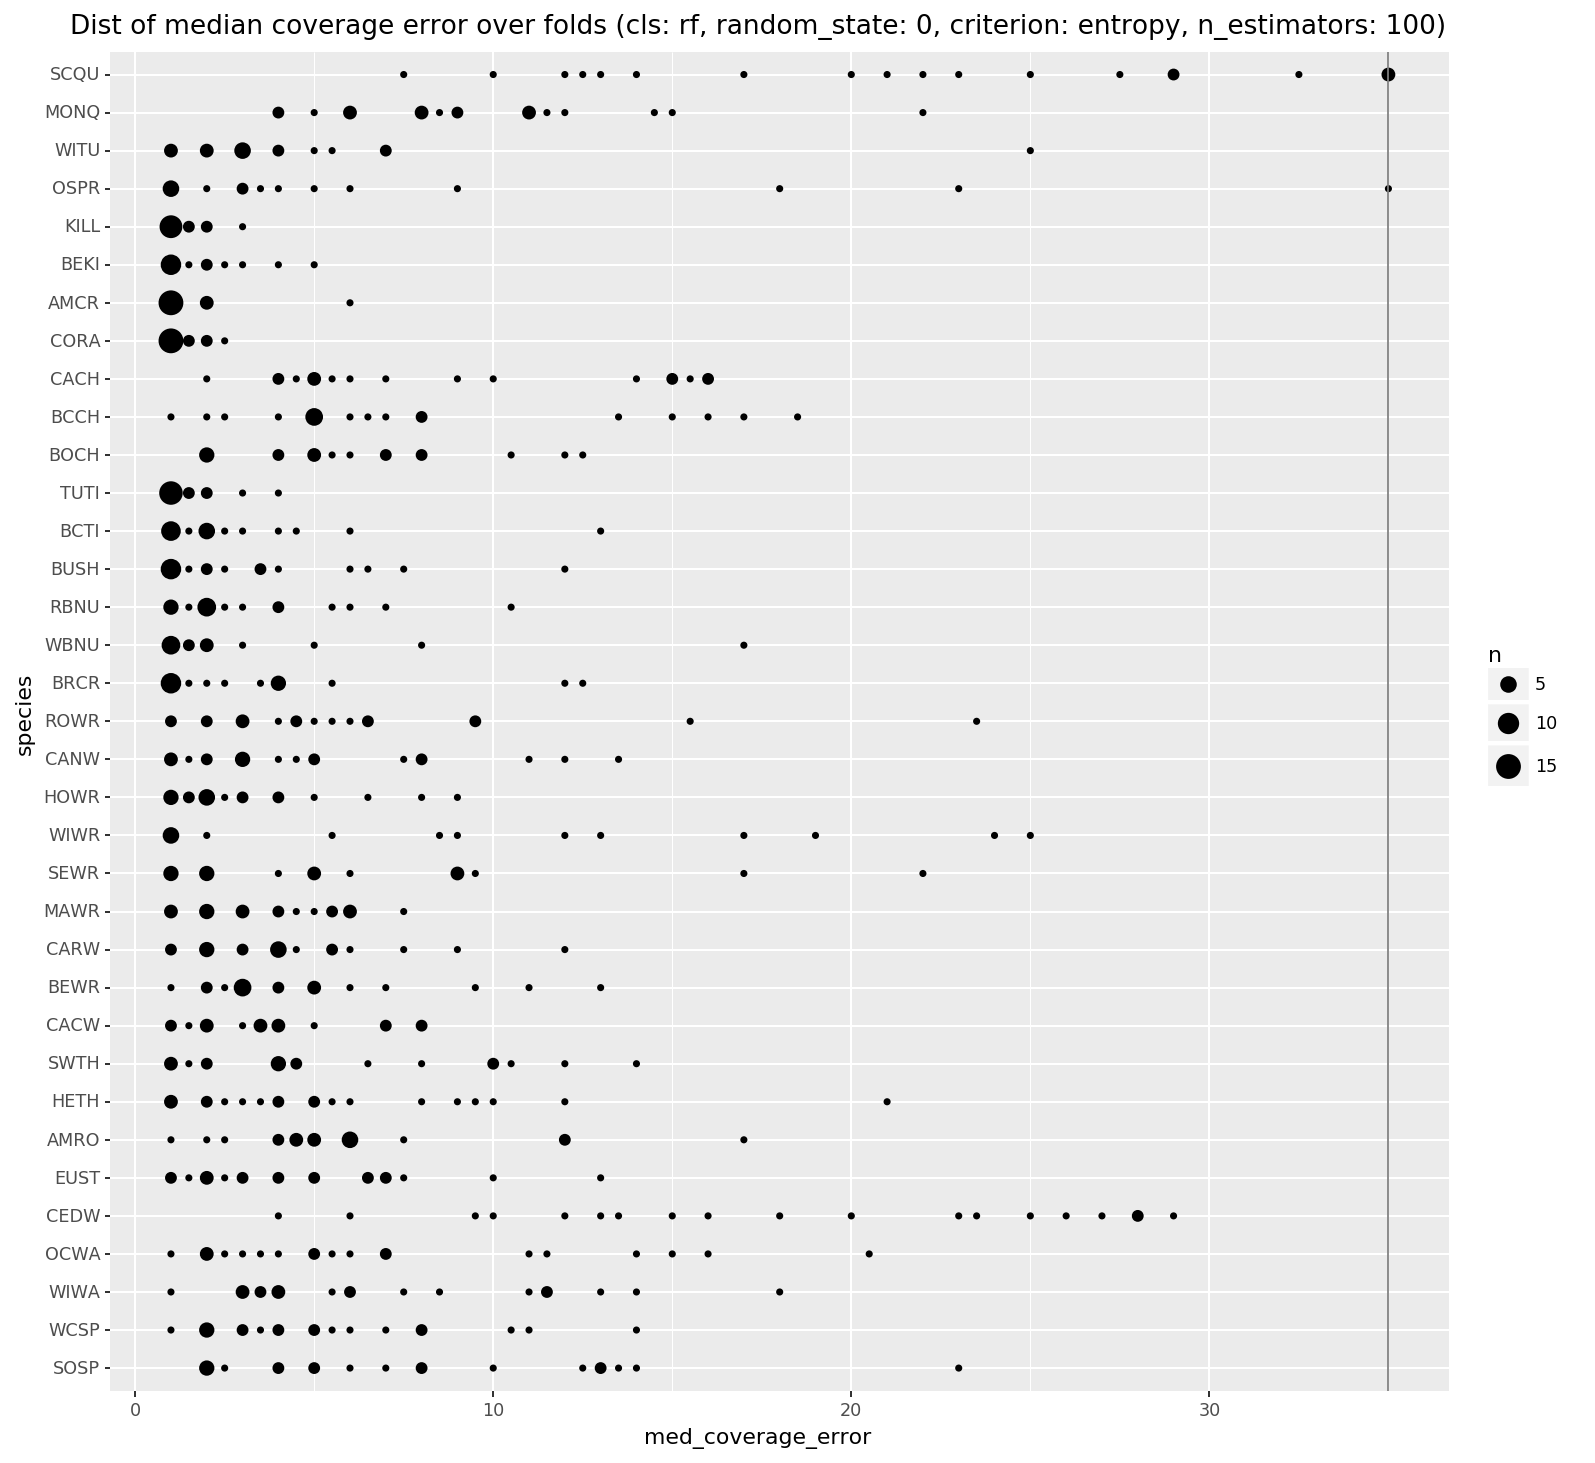

<ggplot: (-9223372036266387035)>

In [ ]:
# in: coverage_errors_by_species, recs
(coverage_errors_by_species
    .pipe(ggplot, aes(x='species', y='med_coverage_error'))
    + geom_count(aes(size='..n..'))
    + coord_flip()
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_x_discrete(limits=list(reversed(recs.species.cat.categories)))
    + theme_figsize('square')
    + ggtitle(f'Dist of median coverage error over folds ({param_classifier})')
)

# Model diagnostics: one model, one fold

In [ ]:
fold = 11
# param_classifier_i = ...  # Leave commented to reuse from above
param_classifier = params['classifier'][param_classifier_i]
[(_, model)] = list(models[lambda df: (df.param_classifier == param_classifier) & (df.fold == fold)].iterrows())
print("params['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(params['classifier'])))
print()
print('model:')
print('  param_classifier[%s/%s]: %r' % (param_classifier_i, len(params['classifier']), model.param_classifier))
print('  fold[%s/%s]' % (model.fold, select.cv.n_splits))
print()
print(model)

In [ ]:
# in: model
model_id = model.model_id
param_classifier = model.param_classifier
fold = model.fold
train_i = model.train_i
test_i = model.test_i
search = model.search

# in: model, recs
train_recs = recs.iloc[model.train_i]
train_X = Search.X(recs)[model.train_i]
train_y = Search.y(recs)[model.train_i]
test_recs = recs.iloc[model.test_i]
test_X = Search.X(recs)[model.test_i]
test_y = Search.y(recs)[model.test_i]

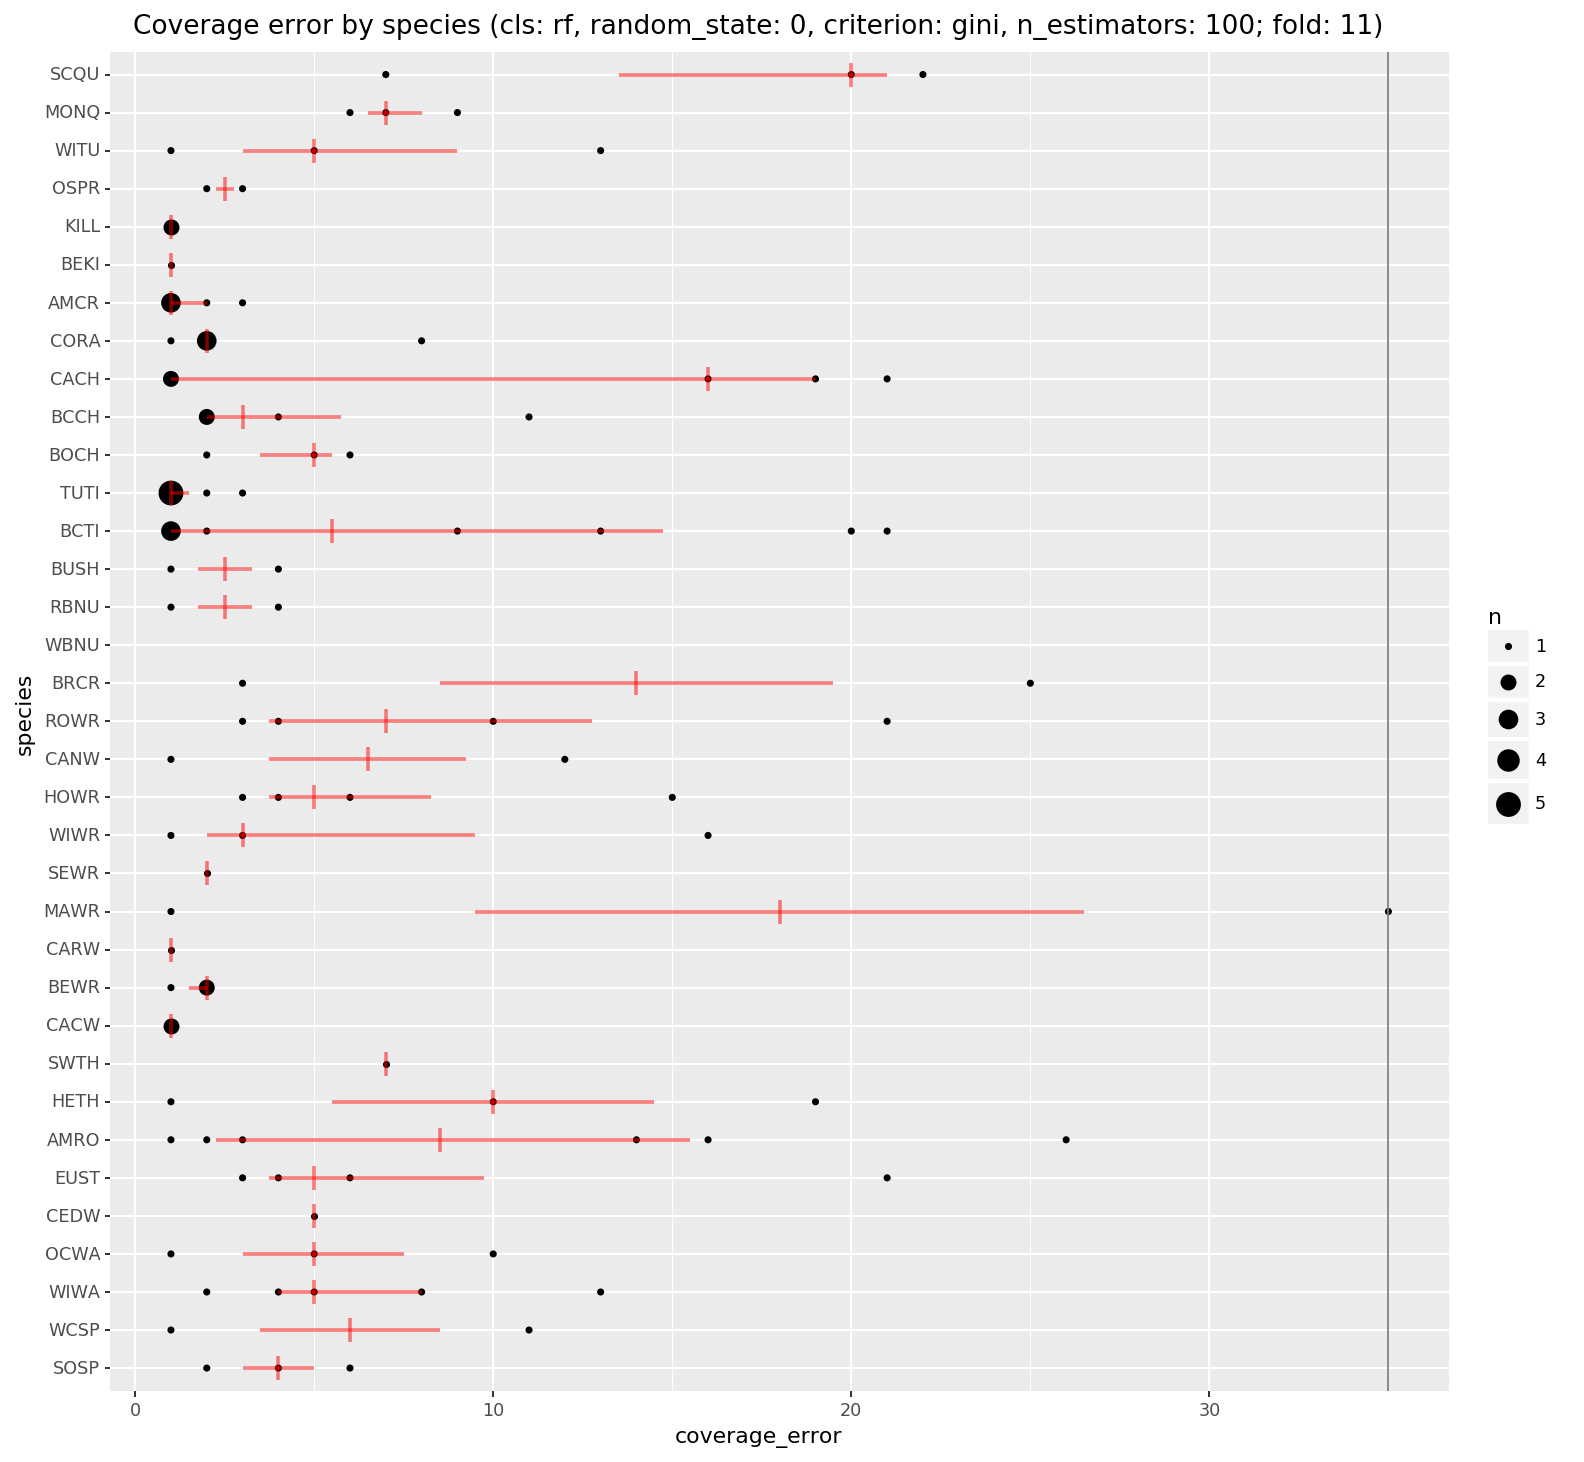

<ggplot: (-9223372036266840232)>

In [ ]:
(search.coverage_errors_recs_by(test_recs, 'id')
    .merge(test_recs[['id', 'species']], on='id', how='left')
    .pipe(ggplot, aes(x='species', y='coverage_error'))
    + geom_count(aes(size='..n..'))
    + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
    + stat_summary(
        fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75), geom='linerange', color='red', alpha=.5, size=1,
    )
    + coord_flip()
    + geom_hline(yintercept=len(search.classes_), color='grey')
    + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
    + theme_figsize('square')
    + ggtitle(f'Coverage error by species ({model_id})')
)

[02:01:22.987] Search.confusion_matrix
  M: [35, 35]


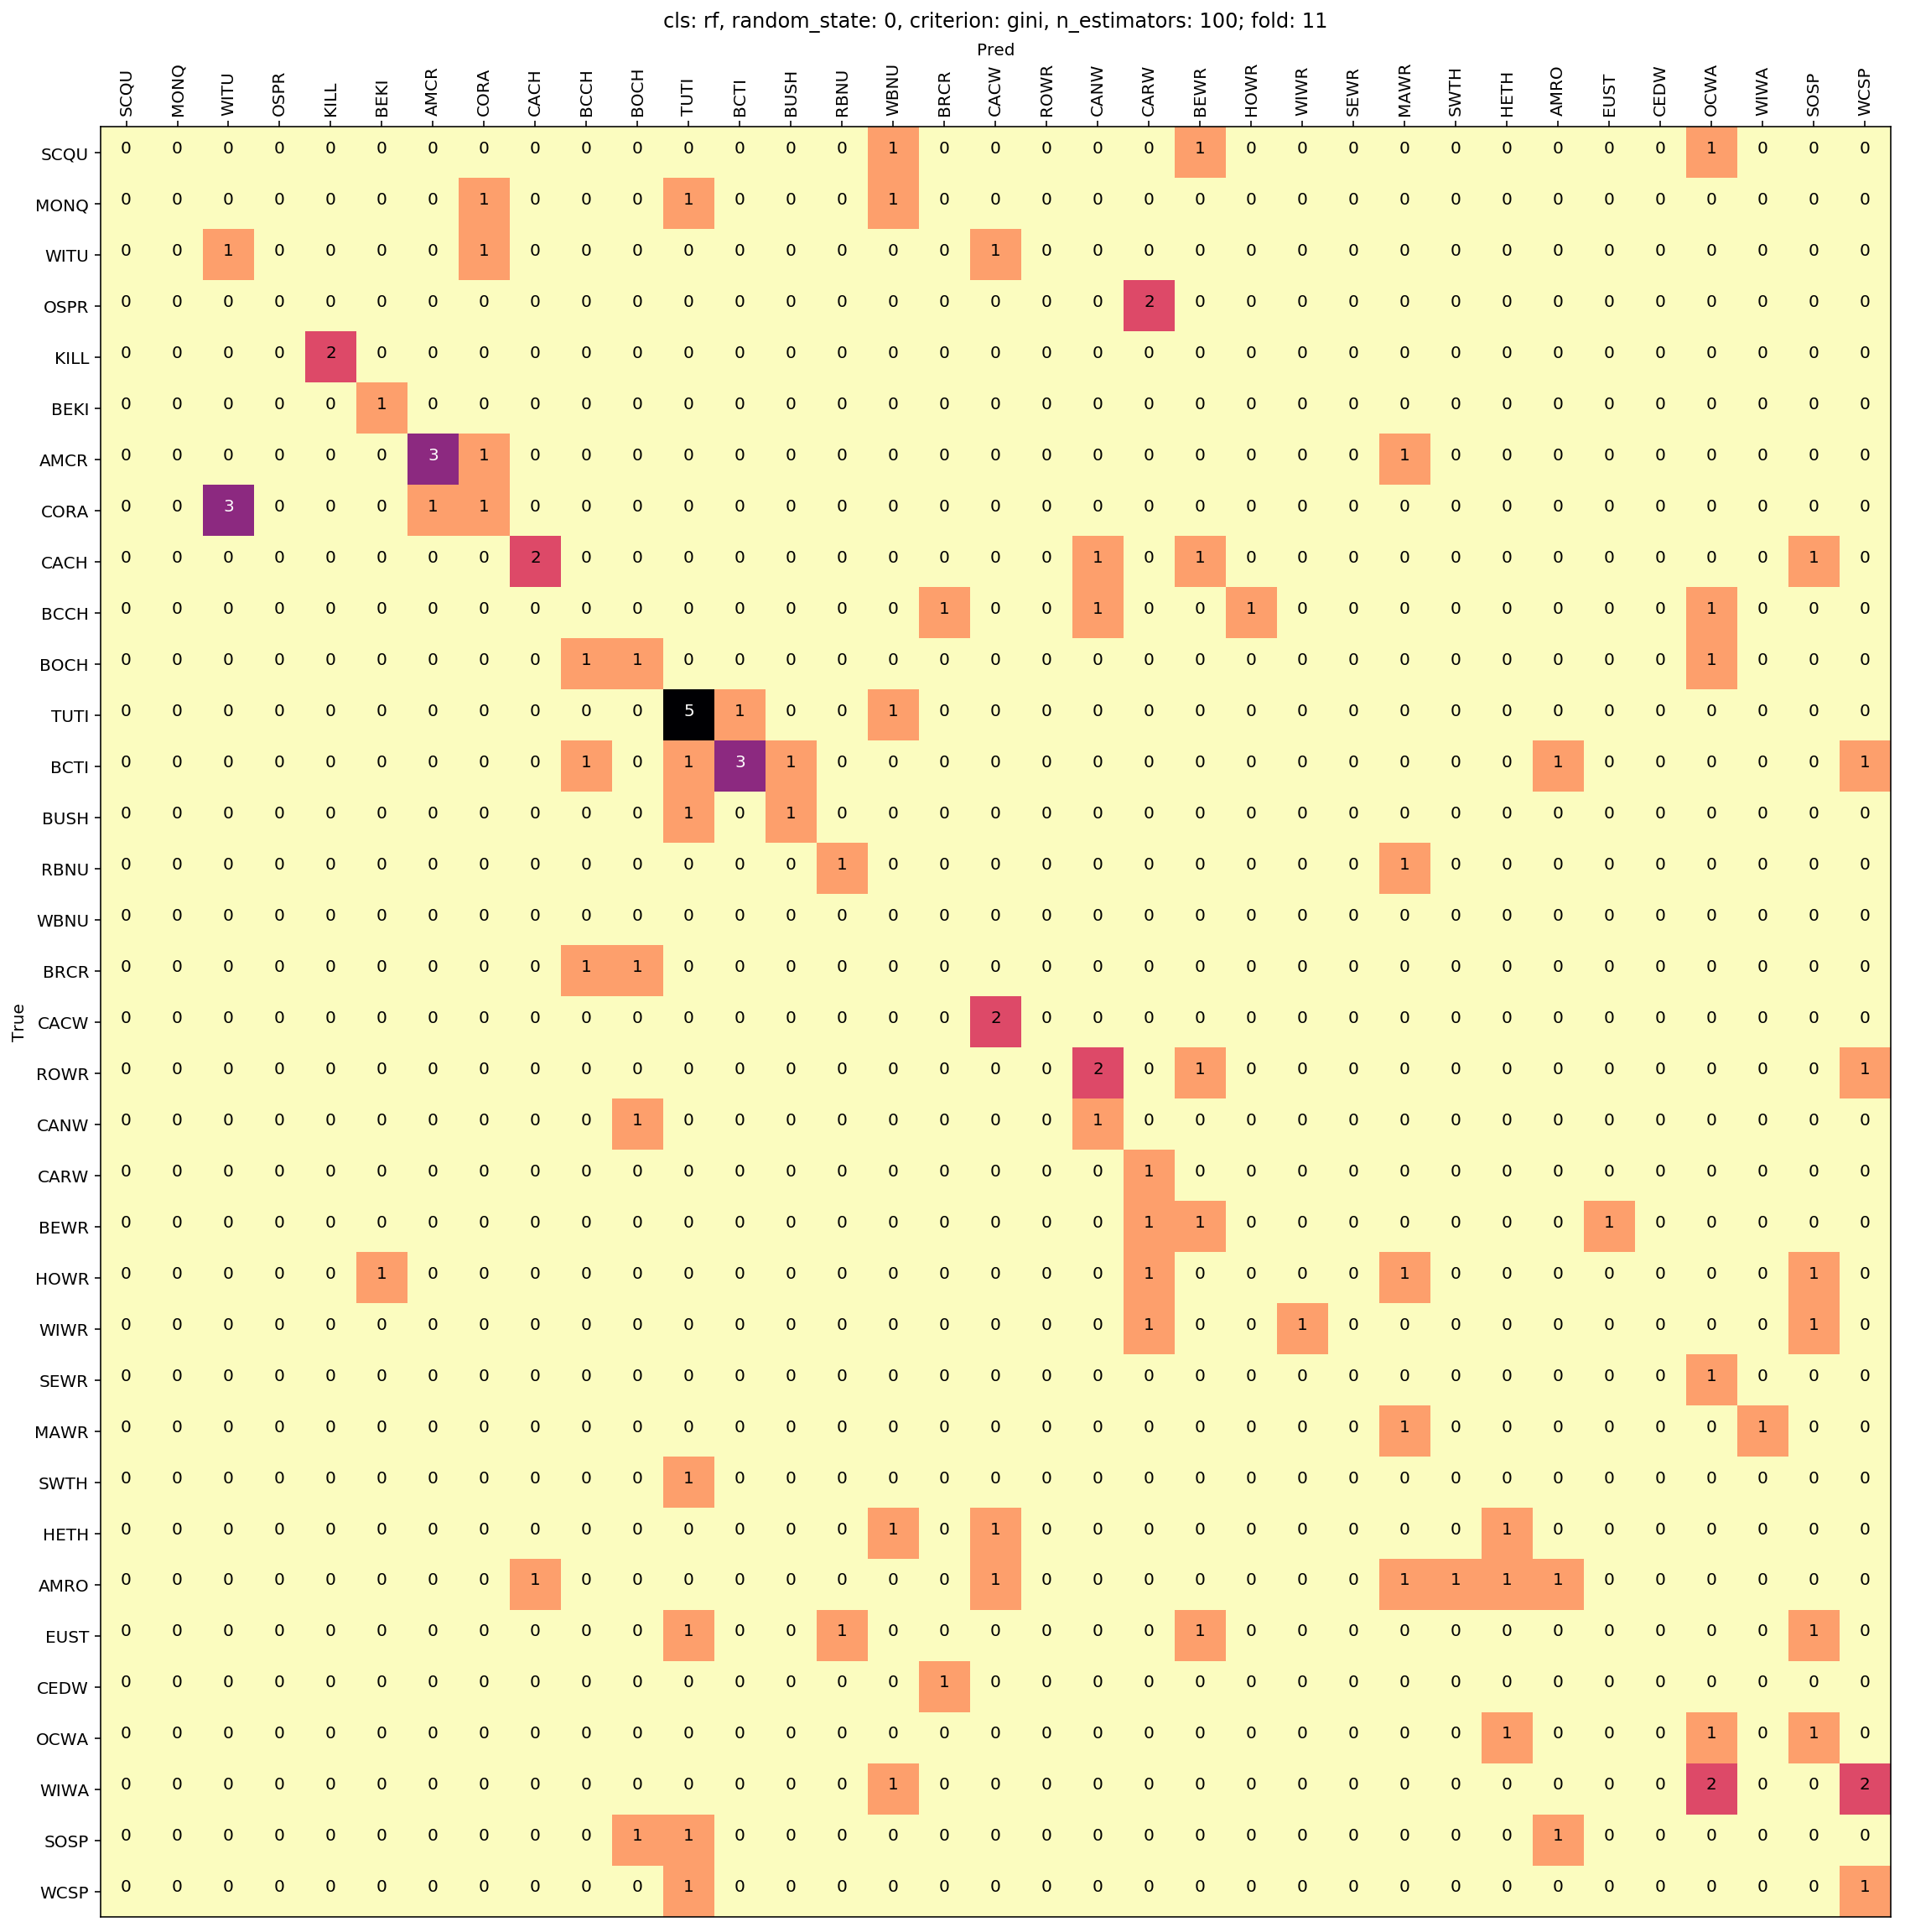

In [ ]:
with figsize('full'):
    search.plot_confusion_matrix(test_recs, title=model_id)